In [1]:
import os
import cv2
import numpy as np
import boto3
from PIL import Image
import io
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

import pandas as pd

from model_hyperparameters import hyperparameters_dict

In [2]:
def load_images_and_labels(bucket_name, folder_prefix):
    s3_client = boto3.client('s3')
    
    image_data = []
    labels = []
    
    response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=folder_prefix)
    
    for item in response.get('Contents', []):
        key = item['Key']
        
        if key.endswith('/'):
            continue
        
        label = key.split('/')[-2]
        
        image_obj = s3_client.get_object(Bucket=bucket_name, Key=key)
        image_data_stream = image_obj['Body'].read()
        
        image = Image.open(io.BytesIO(image_data_stream)).convert('RGB')
        image_np = np.array(image)
        
        image_data.append(image_np)
        labels.append(label)
    
    return np.array(image_data), np.array(labels)

In [3]:
data = "ck"
bucket_name = 'thesissagemakerbucket'
train_path = f'{data}/train'
test_path = f'{data}/test'

X_train, y_train = load_images_and_labels(bucket_name, train_path)
X_test, y_test = load_images_and_labels(bucket_name, test_path)

In [4]:
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

# split into training and testing data using sklearn
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test_and_val,
                                                y_test_and_val,
                                                test_size=0.5,
                                                random_state=42)

In [5]:
X_train_scaled = np.array(X_train) / 255.0
X_test_scaled = np.array(X_test) / 255.0

In [6]:
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], -1)

In [7]:
# map the labels to integers
label_mapping = {label: i for i, label in enumerate(np.unique(y_train))}
label_mapping

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'sadness': 5,
 'surprise': 6}

In [8]:
y_train_mapped = np.array([label_mapping[label] for label in y_train])
y_test_mapped = np.array([label_mapping[label] for label in y_test])

y_train_mapped[:10]

array([0, 0, 4, 2, 2, 5, 0, 6, 5, 4])

In [9]:
# get class weights
class_weights = {}
for label in np.unique(y_train_mapped):
    class_weights[label] = len(y_train_mapped) / np.sum(y_train_mapped == label)

class_weights

{0: 7.424242424242424,
 1: 15.806451612903226,
 2: 4.94949494949495,
 3: 13.61111111111111,
 4: 5.051546391752577,
 5: 13.61111111111111,
 6: 3.92}

In [10]:
class ModelTrainer():
    def __init__(self, model):
        self.model = model

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def hyperparameter_tuning(self,
                              X_train,
                              y_train,
                              param_grid,
                              cv=10):
        grid_search = GridSearchCV(self.model,
                                   param_grid,
                                   cv=cv,
                                   scoring="f1_macro")
        grid_search.fit(X_train, y_train)

        self.model = grid_search.best_estimator_

        return grid_search.best_params_

    def create_label_mapping(self, y_train):
        return {label: i for i, label in enumerate(np.unique(y_train))}

    def plot_confusion_matrix(self, y_true, y_pred, label_mapping, model_name):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm,
                    annot=True,
                    fmt='d',
                    cmap='Blues',
                    xticklabels=label_mapping.keys(),
                    yticklabels=label_mapping.keys())
        plt.title(model_name)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    def calculate_metrics(self, y_true, y_pred):
        accuracy = round(accuracy_score(y_true, y_pred), 2)
        precision = round(precision_score(y_true, y_pred, average='macro'), 2)
        recall = round(recall_score(y_true, y_pred, average='macro'), 2)
        f1 = round(f1_score(y_true, y_pred, average='macro'), 2)

        metrics = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1
        }

        return pd.DataFrame(metrics, index=['Evaluation'])

    def eval(self, X_test, y_test, label_mapping, model_name):
        y_pred = self.model.predict(X_test)

        self.plot_confusion_matrix(y_test, y_pred, label_mapping, model_name)

        print(classification_report(y_test, y_pred, target_names=label_mapping))

        return self.calculate_metrics(y_test, y_pred)



In [11]:
lr = ModelTrainer(LogisticRegression(class_weight=class_weights, n_jobs=-1))

lr.train(X_train_reshaped, y_train_mapped)
#lr_best_parameters = lr.hyperparameter_tuning(X_train_reshaped,
#                                            y_train_mapped,
#                                            hyperparameters_dict["logistic_regression"])

/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
#lr_best_parameters

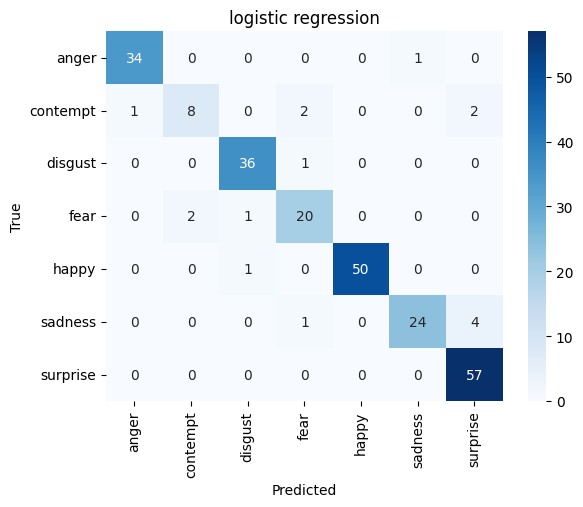

              precision    recall  f1-score   support

       anger       0.97      0.97      0.97        35
    contempt       0.80      0.62      0.70        13
     disgust       0.95      0.97      0.96        37
        fear       0.83      0.87      0.85        23
       happy       1.00      0.98      0.99        51
     sadness       0.96      0.83      0.89        29
    surprise       0.90      1.00      0.95        57

    accuracy                           0.93       245
   macro avg       0.92      0.89      0.90       245
weighted avg       0.93      0.93      0.93       245



,Accuracy,Precision,Recall,F1
Evaluation,0.93,0.92,0.89,0.9


In [13]:
lr.eval(X_test_reshaped, y_test_mapped, label_mapping, "logistic regression")

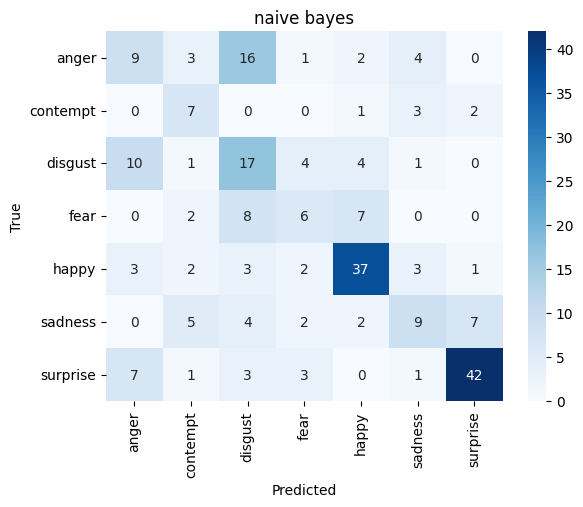

              precision    recall  f1-score   support

       anger       0.31      0.26      0.28        35
    contempt       0.33      0.54      0.41        13
     disgust       0.33      0.46      0.39        37
        fear       0.33      0.26      0.29        23
       happy       0.70      0.73      0.71        51
     sadness       0.43      0.31      0.36        29
    surprise       0.81      0.74      0.77        57

    accuracy                           0.52       245
   macro avg       0.46      0.47      0.46       245
weighted avg       0.53      0.52      0.52       245



,Accuracy,Precision,Recall,F1
Evaluation,0.52,0.46,0.47,0.46


In [15]:
nb = ModelTrainer(GaussianNB())

nb.train(X_train_reshaped, y_train_mapped)

nb.eval(X_test_reshaped, y_test_mapped, label_mapping, "naive bayes")

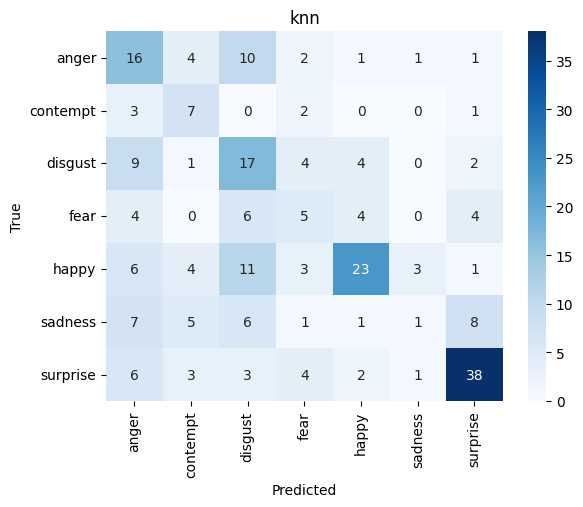

              precision    recall  f1-score   support

       anger       0.31      0.46      0.37        35
    contempt       0.29      0.54      0.38        13
     disgust       0.32      0.46      0.38        37
        fear       0.24      0.22      0.23        23
       happy       0.66      0.45      0.53        51
     sadness       0.17      0.03      0.06        29
    surprise       0.69      0.67      0.68        57

    accuracy                           0.44       245
   macro avg       0.38      0.40      0.38       245
weighted avg       0.45      0.44      0.43       245



,Accuracy,Precision,Recall,F1
Evaluation,0.44,0.38,0.4,0.38


In [16]:
knn = ModelTrainer(KNeighborsClassifier(n_jobs=-1))

knn.train(X_train_reshaped, y_train_mapped)

knn.eval(X_test_reshaped, y_test_mapped, label_mapping, "knn")

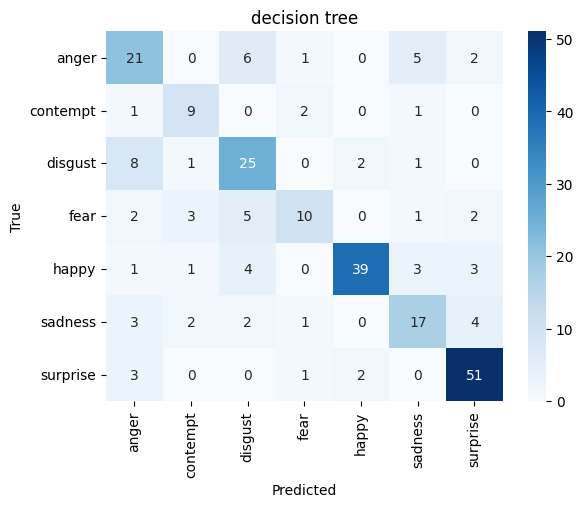

              precision    recall  f1-score   support

       anger       0.54      0.60      0.57        35
    contempt       0.56      0.69      0.62        13
     disgust       0.60      0.68      0.63        37
        fear       0.67      0.43      0.53        23
       happy       0.91      0.76      0.83        51
     sadness       0.61      0.59      0.60        29
    surprise       0.82      0.89      0.86        57

    accuracy                           0.70       245
   macro avg       0.67      0.66      0.66       245
weighted avg       0.71      0.70      0.70       245



,Accuracy,Precision,Recall,F1
Evaluation,0.7,0.67,0.66,0.66


In [17]:
dt = ModelTrainer(DecisionTreeClassifier(class_weight=class_weights))

dt.train(X_train_reshaped, y_train_mapped)

dt.eval(X_test_reshaped, y_test_mapped, label_mapping, "decision tree")

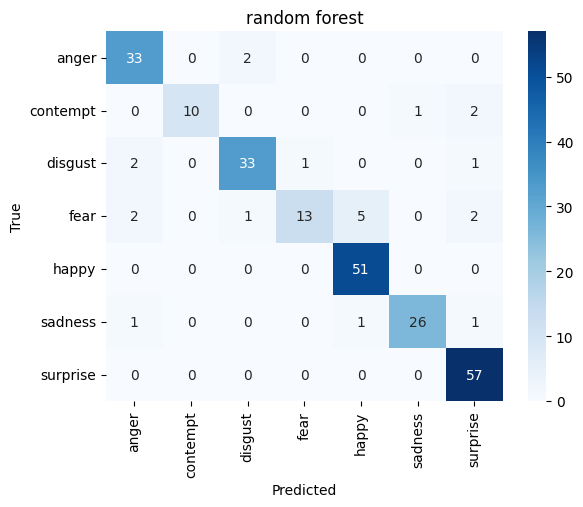

              precision    recall  f1-score   support

       anger       0.87      0.94      0.90        35
    contempt       1.00      0.77      0.87        13
     disgust       0.92      0.89      0.90        37
        fear       0.93      0.57      0.70        23
       happy       0.89      1.00      0.94        51
     sadness       0.96      0.90      0.93        29
    surprise       0.90      1.00      0.95        57

    accuracy                           0.91       245
   macro avg       0.93      0.87      0.89       245
weighted avg       0.91      0.91      0.91       245



,Accuracy,Precision,Recall,F1
Evaluation,0.91,0.93,0.87,0.89


In [18]:
rf = ModelTrainer(RandomForestClassifier(class_weight=class_weights,n_jobs=-1))

rf.train(X_train_reshaped, y_train_mapped)
#rf_best_parameters = rf.hyperparameter_tuning(X_train_reshaped,
#                                            y_train_mapped,
#                                            hyperparameters_dict["random_forest"])

rf.eval(X_test_reshaped, y_test_mapped, label_mapping, "random forest")

/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:04:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sample_weight" } are not used.

  warnings.warn(smsg, UserWarning)


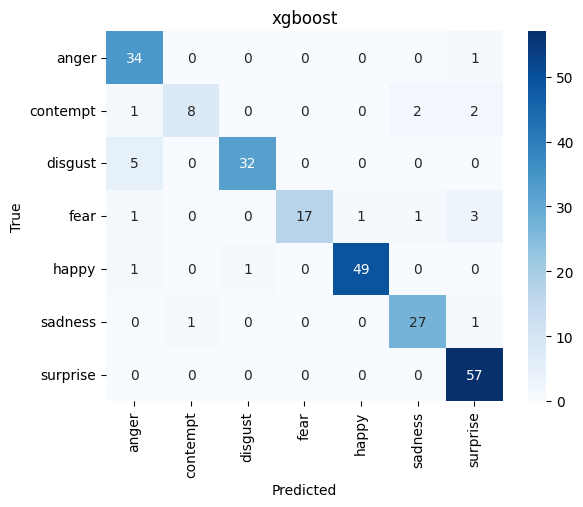

              precision    recall  f1-score   support

       anger       0.81      0.97      0.88        35
    contempt       0.89      0.62      0.73        13
     disgust       0.97      0.86      0.91        37
        fear       1.00      0.74      0.85        23
       happy       0.98      0.96      0.97        51
     sadness       0.90      0.93      0.92        29
    surprise       0.89      1.00      0.94        57

    accuracy                           0.91       245
   macro avg       0.92      0.87      0.89       245
weighted avg       0.92      0.91      0.91       245



,Accuracy,Precision,Recall,F1
Evaluation,0.91,0.92,0.87,0.89


In [19]:
# train xgboost

xgb = ModelTrainer(XGBClassifier(sample_weight=class_weights))

xgb.train(X_train_reshaped, y_train_mapped)
# xgb_best_parameters = xgb.hyperparameter_tuning(X_train_reshaped,
#                                             y_train_mapped,
#                                             hyperparameters_dict["xgboost"])

xgb.eval(X_test_reshaped, y_test_mapped, label_mapping, "xgboost")

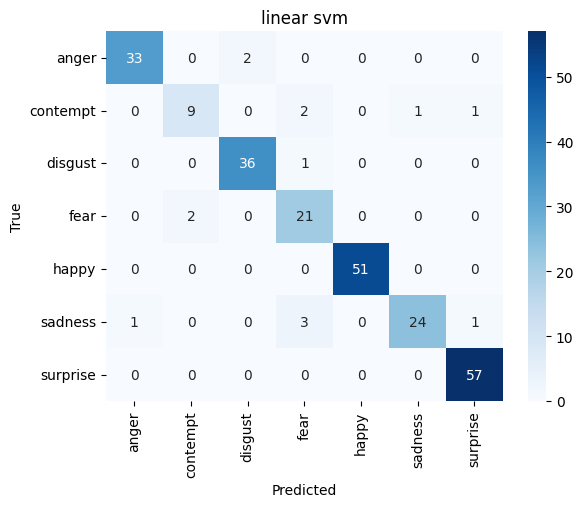

              precision    recall  f1-score   support

       anger       0.97      0.94      0.96        35
    contempt       0.82      0.69      0.75        13
     disgust       0.95      0.97      0.96        37
        fear       0.78      0.91      0.84        23
       happy       1.00      1.00      1.00        51
     sadness       0.96      0.83      0.89        29
    surprise       0.97      1.00      0.98        57

    accuracy                           0.94       245
   macro avg       0.92      0.91      0.91       245
weighted avg       0.94      0.94      0.94       245



,Accuracy,Precision,Recall,F1
Evaluation,0.94,0.92,0.91,0.91


In [20]:
# train SVM
from sklearn.svm import SVC

svm = ModelTrainer(SVC(kernel="linear"))

svm.train(X_train_reshaped, y_train_mapped)

svm.eval(X_test_reshaped, y_test_mapped, label_mapping, "linear svm")